In [54]:
from __future__ import print_function
import os
import sys
import numpy as np
from keras.models import load_model

sys.path.append('..')
from utils import load_and_pair_data, manual_train_test_split, RotNetDataGenerator, angle_error_regression

In [55]:
model_location = os.path.join('..', 'models', 'rotnet_carcass_regression.hdf5')
model = load_model(model_location, custom_objects={'angle_error_regression': angle_error_regression})
model.summary()

image_dir = r"C:\Users\xuyan\RotNet\data\RotationAngle\DATASET\STANDARDIZED\cut_masks"
csv_path = r"C:\Users\xuyan\RotNet\data\RotationAngle\DATASET\dataset_image_rotation_data.csv"

images, angles = load_and_pair_data(image_dir, csv_path,target_size=(96, 128))

X_train, X_test, y_train, y_test = manual_train_test_split(images, angles, test_size=0.2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 96, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 94, 128)      1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 94, 128)      512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 47, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 47, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 45, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 45, 256)       1024  

In [56]:
batch_size = 32
out = model.evaluate(
    X_test,y_test,
    steps=len(y_test) / batch_size
)

print('Test loss:', out)

20/20 [==============================] - 2s 53ms/step - loss: 4.6703
Test loss: 4.670260906219482


In [ ]:
y_pred = model.predict(X_test)
# 打印真实标签和预测标签
print("真实标签 (y_true):")
print(y_test)
print("预测标签 (y_pred):")
for value in y_pred.flatten():
    print(f"{value:.1f}")

真实标签 (y_true):
[  -4.    38.   -30.    11.     1.   -44.     1.     3.    -5.3   10.
    0.5    3.    -8.     4.4    0.3    5.     1.   -34.   -54.   -45.
  -42.     9.    -1.9  -11.   -39.   -40.    -4.     5.    -2.     6.
   -3.   -50.   -25.    -1.    -1.   -11.     9.     8.    -5.   -48.
    3.     4.     7.    -1.   -53.     4.    27.     4.   -18.   -27.7
  -28.     3.   -45.     6.     9.   -14.    -6.   -11.    -4.     1.
   11.   -17.9    3.     1.   -42.     1.     0.     8.   -16.     8.
   12.    41.     0.    -5.   -47.    37.  -108.   -62.    -9.     5.
    1.     1.     4.    -4.6   -5.     7.   -31.     7.    12.    -4.
    1.    -1.   -39.   -30.     5.     3.3    0.6  -41.   -43.   -27.
  -33.    10.    -4.     2.     7.    -6.     9.   -10.     2.     5.
  -37.    -6.    -7.1  -48.   -44.   -34.   -12.   -50.     3.   -63.
    4.    -2.     8.   -19.   -42.   -40.    -8.     9.     7.    13.
    9.     0.     5.2  -40.5  -33.    15.     3.    -5.    -3.   -61.
    

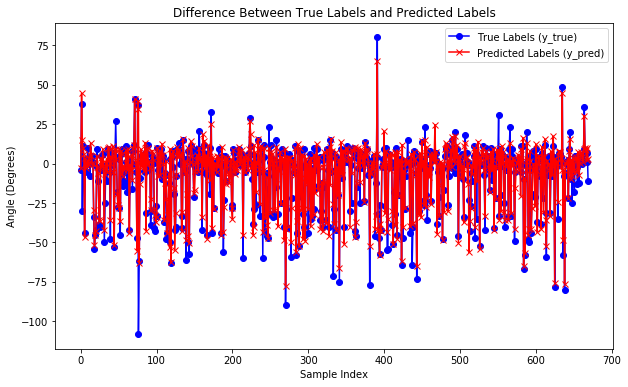

In [62]:
import matplotlib.pyplot as plt

# Predict labels
y_pred = model.predict(X_test)

# Plot the difference between true labels and predicted labels using line plots
plt.figure(figsize=(10, 6))

# Plot the true labels as a line
plt.plot(y_test, label="True Labels (y_true)", color='b', linestyle='-', marker='o')

# Plot the predicted labels as a line
plt.plot(y_pred, label="Predicted Labels (y_pred)", color='r', linestyle='-', marker='x')

# Add title and labels to the plot
plt.title("Difference Between True Labels and Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Angle (Degrees)")
plt.legend()

# Display the plot
plt.show()

